In [85]:
from dataclasses import dataclass, field
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
%matplotlib inline
from data_science import PrepTools, ModelSelectionTools
from gauss_rank_scaler import GaussRankScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, Model
from tensorflow.keras.losses import binary_crossentropy, Loss
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop, Adagrad, Adadelta, Adamax
from tensorflow.keras.utils import plot_model
import sys
sys.path.append("/Users/atticussoane/Retrosheet/tools/")
from bankroll_calc import BankrollCalculator
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option("max.columns", 200)

df = pd.read_csv("./adv_metrics/current.csv.gz", compression = "gzip")

with open("./adv_metrics/adv_metrics_drop_cols.json", "r+") as f:
    
    remove = json.load(f)
    
df.head()

,date,home_close_TJ,home_close_ou,home_closing,home_open_TJ,home_open_ou,home_opening,home_runline,home_runline_juice,is_doubleheader,road_close_TJ,road_close_ou,road_closing,road_open_TJ,road_open_ou,road_opening,road_runline,road_runline_juice,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP,home_payout,road_payout,elo1_pre,elo2_pre,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,score1,score2,home_win,home_favorite,line_movement,money_scalar,batting_park_factor,home_streak,home_H_streak,home_record,run_differential_hm,avg_margin_hm,distance_traveled,road_streak,road_R_streak,road_record,run_differential_rd,avg_margin_rd
0,2010-04-04,-115,9.0,-117.0,-104,9.0,-114.0,NaN,NaN,0,-105,9.0,107.0,-116,9.0,104.0,NaN,NaN,0.0,2010.0,BOS,NYY,beckj002,sabac001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.854701,2.070000,1537.262,1568.875,1536.601,1562.673,57.031,61.828,27.349300,46.7039,0.471714,9.0,7.0,1,1,1,-3.0,106.0,0.0,0.0,0.0,0.0,0.0,289.0,0.0,0.0,0.0,0.0,0.0
1,2010-04-05,105,7.5,175.0,-120,7.5,175.0,NaN,NaN,0,-125,7.5,-200.0,100,7.5,-200.0,NaN,NaN,0.0,2010.0,WSN,PHI,lannj001,hallr001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000,1.500000,1460.859,1541.211,1460.662,1537.875,49.834,62.166,8.394200,49.4957,0.366599,1.0,11.0,0,0,0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,0.0,0.0,0.0
2,2010-04-05,-105,7.0,137.0,-105,7.0,110.0,NaN,NaN,0,-115,7.0,-152.0,-115,7.0,-125.0,NaN,NaN,0.0,2010.0,OAK,SEA,sheeb001,hernf002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.370000,1.657895,1509.222,1501.778,1513.910,1500.945,56.701,60.524,7.593298,46.4172,0.501246,3.0,5.0,0,0,-1,27.0,99.0,0.0,0.0,0.0,0.0,0.0,1095.0,0.0,0.0,0.0,0.0,0.0
3,2010-04-05,110,8.5,-128.0,100,8.5,-135.0,NaN,NaN,0,-130,8.5,113.0,-120,8.5,120.0,NaN,NaN,0.0,2010.0,ANA,MIN,weavj003,bakes002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.781250,2.130000,1544.703,1521.978,1543.114,1520.771,54.034,55.637,16.337200,26.8276,0.550540,6.0,3.0,1,1,-1,7.0,96

In [3]:
train_target = df[df.season < 2019][["home_win", "home_payout", "road_payout"]]

validation_target = df[df.season == 2019][["home_win", "home_payout", "road_payout"]].reset_index(drop = True)

train = df[df.season < 2019].drop(columns = remove + ["home_win", "home_payout", 
                                                      "road_payout", "date", "season"])

validation = df[df.season == 2019].drop(columns = remove + ["home_win", "home_payout", "road_payout", 
                                                            "date", "season"]).reset_index(drop = True)

train.shape, train_target.shape, validation.shape, validation_target.shape

((21554, 80), (21554, 3), (2384, 80), (2384, 3))

In [4]:
test_dates = df[df.season == 2019].date.reset_index(drop = True)

test_homeC = df[df.season == 2019].home_closing.reset_index(drop = True)

test_roadC = df[df.season == 2019].road_closing.reset_index(drop = True)

# FEATURE SCALING

### Two different approaches - 
* StandardScaler: $\bigg(\mu,\sigma\bigg)\:=\:\bigg(0, 1\bigg)$
* Gauss Rank Scaler - Rank features: $\epsilon \bigg(-1, 1\bigg)$, apply inverse of error function defined as $ \displaystyle\frac{2}{\sqrt{\pi}}\:*\:\int_{t=0}^{z} e^{-t^{2}}$ to force a normal distribution. The mathematical reasoning: Given a random variable Z with $\mu = 0$ and $\sigma =  \frac{1}{2}$, error($x$) is the probability that Z falls between $[-x, x]$. Thus, applying the inverse of the error function to sorted and ranked distribution of $[-x, x]$ yields a normal distribution.

In [5]:
ss_train, ss = PrepTools(train, train_target).scale_features(save_scaler = True)

ss_test = PrepTools(validation, validation_target).scale_features(load_scaler = ss)

In [6]:
feature_cols = list(train.columns)

GRS = GaussRankScaler()

GRS.fit(train)

gr_train = pd.DataFrame(GRS.transform(train))

gr_test = pd.DataFrame(GRS.transform(validation))

gr_train.columns, gr_test.columns = feature_cols, feature_cols

In [7]:
rb = RobustScaler().fit(train)

rb_train = pd.DataFrame(rb.transform(train))

rb_test = pd.DataFrame(rb.transform(validation))

rb_train.columns, rb_test.columns = feature_cols, feature_cols

In [8]:
pt = PowerTransformer().fit(train)

pt_train = pd.DataFrame(pt.transform(train))

pt_test = pd.DataFrame(pt.transform(validation))

pt_train.columns, pt_test.columns = feature_cols, feature_cols

In [9]:
qt = QuantileTransformer(output_distribution = "normal").fit(train)

qt_train = pd.DataFrame(qt.transform(train))

qt_test = pd.DataFrame(qt.transform(validation))

qt_train.columns, qt_test.columns = feature_cols, feature_cols

# PCA Analysis

Like to do PCA to get idea for reduction dimension for AutoEncoder.

### Standard

In [10]:
def plot_pca(data: pd.core.frame.DataFrame, scaler: str = None):
    
    pca = PCA().fit(data)

    explained_variance = pd.DataFrame(pca.explained_variance_ratio_)

    explained_variance = explained_variance.rename(columns = {0 : 'var_proportion'})

    explained_variance['total_variance_explained'] = explained_variance.var_proportion.cumsum()

    _90 = explained_variance[explained_variance.total_variance_explained > 0.90].idxmin().values[1]

    _95 = explained_variance[explained_variance.total_variance_explained > 0.95].idxmin().values[1]

    fig, ax = plt.subplots(figsize = (15, 4))

    ax.plot(np.cumsum(pca.explained_variance_ratio_))

    ax.axhline(0.90, ls = "--", c = "r", xmin = 0., xmax = 1)

    ax.axhline(0.95, ls = "--", c = "g", xmin = 0., xmax = 1.)

    ax.axvline(_90, ls = "--", c = "r", ymin = 0, ymax = 1)

    ax.axvline(_95, ls = "--", c = "g", ymin = 0., ymax = 1.)

    s = "\n".join(["Number of components to explain 90% of variance: {}".format(_90),
                 "Number of components to explain 95% of variance: {}".format(_95)])
    
    text_box = {

        "boxstyle" : "square",

        "facecolor" : "mistyrose",

        "edgecolor" : "k",

        "alpha" : 0.5
    }

    ax.text(0.55, 0.05, s, transform = ax.transAxes, fontsize = 12, 
    bbox = text_box)

    ax.set_xlabel("Number of Components")

    ax.set_ylabel("Cumulative Explained Variance")

    ax.set_title("PCA Scree Plot- {}".format(scaler));

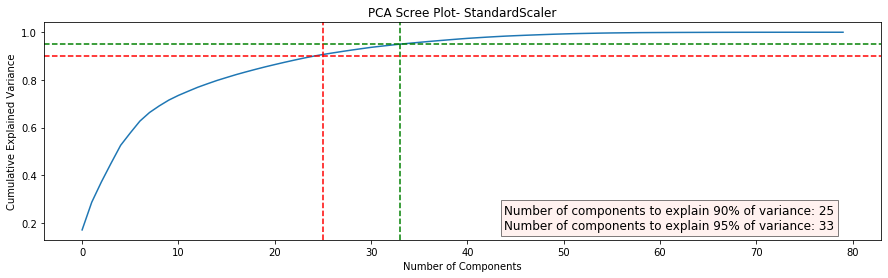

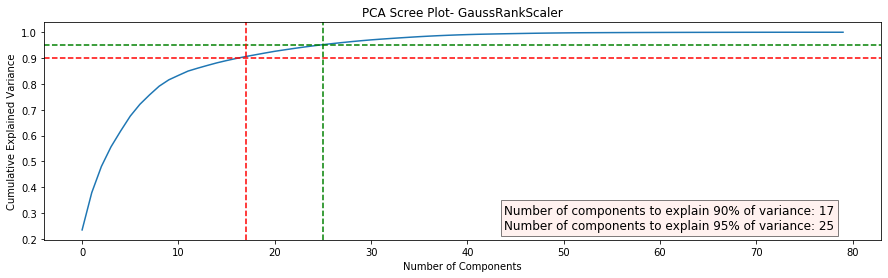

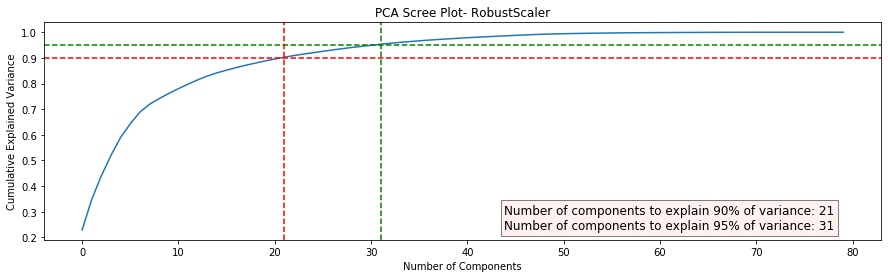

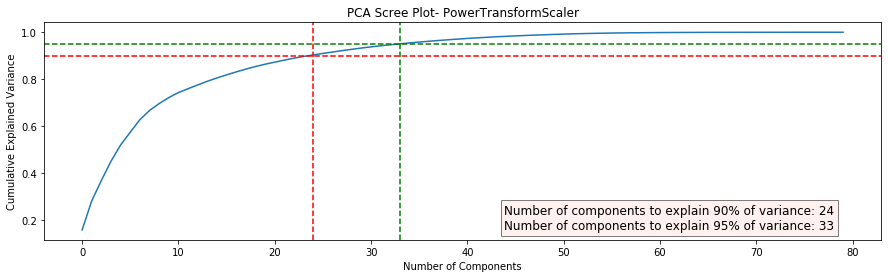

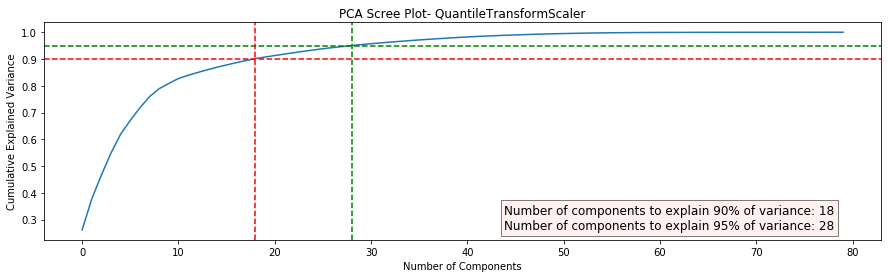

In [11]:
data = [(ss_train, "StandardScaler"), (gr_train, "GaussRankScaler"), (rb_train, "RobustScaler"),
        (pt_train, "PowerTransformScaler"),  (qt_train, "QuantileTransformScaler")]

for pair in data:
    
    plot_pca(pair[0], pair[1])

#### Wrapper function for pd.Series.isnull() to return all columns with null values

In [12]:
data_test = [(ss_test, "StandardScaler"), (gr_test, "GaussRankScaler"), (rb_test, "RobustScaler"),
        (pt_test, "PowerTransformScaler"),  (qt_test, "QuantileTransformScaler")]

In [13]:
def find_nulls(data):
    
    if type(data) == list:
        
        d = {}
        
        for k in data:
            
            null_cols = []
            
            for col in k[0].columns:
                
                if len(k[0][k[0][col].isnull()]) != 0:
                    
                    null_cols.append((col, len(k[0][k[0][col].isnull()])))
                    
            d[k[1]] = null_cols
            
    return(d)
            
    
null_cols = find_nulls(data_test)

In [14]:
null_cols

{'StandardScaler': [],
 'GaussRankScaler': [('home_opening', 7),
  ('road_opening', 6),
  ('home_wRC', 1),
  ('road_starter_career_wRC', 2),
  ('road_starter_season_wRC', 3),
  ('rating1_pre', 9),
  ('rating2_pre', 3),
  ('home_record', 12),
  ('run_differential_hm', 51)],
 'RobustScaler': [],
 'PowerTransformScaler': [],
 'QuantileTransformScaler': []}

### Problem with the GaussRank scaler... it does not extrapolate: values in the test set that fall outside of the distribution of that feature in the training set are coming back null... While I'm just evaluating scalers, going to drop nulls for now... If the GaussRank scaler tests highly, going to have to look into this. I'm not sure how to extrapolate without re-ranking and re-clipping because the distribution is hardcapped and the erfinv function only exists between (-1, 1) but hopefully the GaussRank scaler will just test badly and I don't need to think about this.

In [15]:
indices = []

for col in gr_test.columns:
    
    indices += list(gr_test[gr_test[col].isnull()].index)
    
indices = set(indices)

print(len(indices))

65


In [16]:
gr_test_dates = df[df.season == 2019].reset_index(drop = True).drop(indices).date.reset_index(drop = True)

gr_hc = df[df.season == 2019].reset_index(drop = True).drop(indices).home_closing.reset_index(drop = True)

gr_rc = df[df.season == 2019].reset_index(drop = True).drop(indices).road_closing.reset_index(drop = True)

In [17]:
gr_test = gr_test.drop(indices, axis = 0).reset_index(drop = True)

gr_test_target = validation_target.drop(indices, axis = 0).reset_index(drop = True)

gr_test.shape, gr_test_target.shape

((2319, 80), (2319, 3))

In [64]:
gr_hp = df[df.season == 2019].reset_index(drop = True).drop(indices).home_payout.reset_index(drop = True)

gr_rp = df[df.season == 2019].reset_index(drop = True).drop(indices).road_payout.reset_index(drop = True)

#### LOT GOING ON HERE... NEED TO INVESTIGATE SOME STUFF.... LOOK INTO PITCHING STATS? 

# DIMENSIONALITY REDUCTION - AE vs. PCA

### AutoEncoder

In [18]:
input_dim = gr_train.shape[1]

_input = Input(shape = (input_dim, ))

encode1 = Dense(80, activation = "relu")(_input)

encode2 = Dense(60, activation = "relu")(encode1)

encode3 = Dense(40, activation = "relu")(encode2)

decode1 = Dense(60, activation = "relu")(encode3)

decode2 = Dense(80, activation = "relu")(decode1)

output = Dense(input_dim, activation = "sigmoid")(decode2)

autoencoder = Model(inputs = _input, outputs = output)

autoencoder.compile(optimizer = "adam", loss = "mean_squared_error")

In [19]:
historyAE = autoencoder.fit(gr_train.values, gr_train.values, epochs = 100, batch_size = 32, 
                validation_data = (gr_test.values, gr_test.values), verbose = 0)

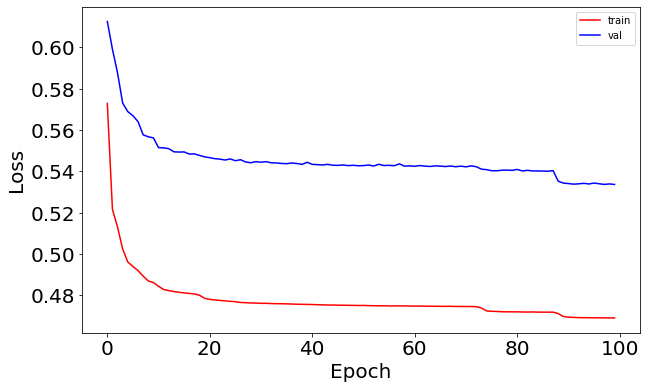

In [20]:
def plot_loss(model_history):

    fig, ax = plt.subplots(1, 1, figsize = (10, 6))

    ax.plot((model_history.history['loss']), 'r', label='train')

    ax.plot((model_history.history['val_loss']), 'b' ,label='val')

    ax.set_xlabel(r'Epoch', fontsize=20)

    ax.set_ylabel(r'Loss', fontsize=20)

    ax.legend()

    ax.tick_params(labelsize=20);
    
plot_loss(historyAE)

In [21]:
encoder = Model(inputs = _input, outputs = encode2)

In [22]:
encoded_train = pd.DataFrame(encoder.predict(gr_train))

encoded_train = encoded_train.add_prefix('feature_')

encoded_test = pd.DataFrame(encoder.predict(gr_test))

encoded_test = encoded_test.add_prefix('feature_')

In [23]:
binary_target = train_target.home_win.values

binary_test = validation_target.home_win.values

gr_test_binary = gr_test_target.home_win.values

### PCA - 95% var

In [24]:
pca33 = PCA(n_components = 33).fit(ss_train)

ssPCA_tr, ssPCA_tst = pca33.transform(ss_train), pca33.transform(ss_test)

pca25 = PCA(n_components = 25).fit(gr_train)

grPCA_tr, grPCA_tst = pca25.transform(gr_train), pca25.transform(gr_test)

pca31 = PCA(n_components = 31).fit(rb_train)

rbPCA_tr, rbPCA_tst = pca31.transform(rb_train), pca31.transform(rb_test)

pca33_ = PCA(n_components = 33).fit(pt_train)

ptPCA_tr, ptPCA_tst = pca33_.transform(pt_train), pca33_.transform(pt_test)

pca28 = PCA(n_components = 28).fit(qt_train)

qtPCA_tr, qtPCA_tst = pca28.transform(qt_train), pca28.transform(qt_test)

### KERAS MODELING

Different ideas I am going to try:

* Autoencoded data. GaussRank scaled data performed extremely well on training set but average on test data even with dropout pct of 0.3 it was still too overfit. Perhaps autoencoded data?
* Custom loss function - Relu, Dual, Trio
* Weighted binary cross-entropy. 

#### FEW GAMBLING LOSS FUNCTIONS TO TRY

In [25]:
def gambling_loss_binary(ytrue, ypreds):
    ''' 
    Callable to calculate gambling loss. Binary classification. Using two labels with softmax for calculation
    purposes as opposed to sigmoid with single output.
    '''
    home_win = ytrue[:, 0:1]
    
    road_win = ytrue[:, 1:2]
    
    odds_home = ytrue[:, 2:3]
    
    odds_road = ytrue[:, 3:4]
    
    profit_tensor = K.concatenate([home_win * (odds_home - 1) + (1 - home_win) * -1,
                                  road_win * (odds_road - 1) + (1 - road_win) * -1],
                                 axis = 1)
    
    return(-1 * K.mean(K.sum(profit_tensor * ypreds, axis = 1)))
    

def gambling_loss_multiclass(ytrue, ypreds):
    '''
    Callable to calculate gambling loss. 3 class multi-class classification. Adding logic for NO BET
    '''
    home_win = ytrue[:, 0:1]
    
    road_win = ytrue[:, 1:2]
    
    odds_home = ytrue[:, 3:4]
    
    odds_road = ytrue[:, 4:5]
    
    profit_tensor = K.concatenate([home_win * (odds_home - 1) + (1 - home_win) * -1,
                                  road_win * (odds_road - 1) + (1 - road_win) * -1,
                                  K.zeros_like(odds_home)], axis = 1)
    
    return(-1 * K.mean(K.sum(profit_tensor * ypreds, axis = 1)))

def gambling_loss_ReLu(ytrue, ypreds): 
    '''
    Callable to calculate gambling loss using ReLu function to simulate gambling strategy 
    '''
    home_win = ytrue[:, 0:1]
    
    odds_home = ytrue[:, 1:2]
    
    odds_road = ytrue[:, 2:3]
    
    return(-K.sum((home_win*odds_home - 1) * K.relu(ypreds *odds_home - 1) +\
    ((home_win - 1)*odds_road - 1)) * K.relu((1 - ypreds)*odds_road - 1))

In [26]:
def road_win(x):
    
    if x == 1:
        
        return(0)
    
    else:
        
        return(1)
    
train_target["road_win"] = train_target.home_win.apply(lambda x: road_win(x))

validation_target["road_win"] = validation_target.home_win.apply(lambda x: road_win(x))

train_target = train_target.assign(no_bet = 0.)

validation_target = validation_target.assign(no_bet = 0.)

train_target = train_target[["home_win", "road_win", "no_bet", "home_payout", "road_payout"]]

validation_target = validation_target[["home_win", "road_win", "no_bet", "home_payout", "road_payout"]]

In [27]:
gr_multi_tst = validation_target.drop(indices).reset_index(drop = True)

In [28]:
train_weights = np.reshape(np.array(train_target.home_payout - 1), -1)

#### WRAPPER CLASS FOR BUILDING / TRAINING ANNs... MAKES IT EASIER TO TUNE ARCHITECTURE / PARAMETERS

In [29]:
@dataclass
class NeuralNetConstructor():
    training: np.ndarray
    train_target: np.ndarray
    validation: np.ndarray = None
    validation_target: np.ndarray = None
    external_validation: bool = False
    objective: str = "binary"
    n_classes: int = None
    n_hidden: int = 0
    base_neurons: int = 500
    shape: str = "funnel"
    funnel_param: float = 0.25
    dropout: bool = False
    dropout_pct: float = 0.3
    kernel_initializer: str = "glorot_normal"
    normalize_batches: bool = False
    model_checkpoint: bool = False
    checkpoint_params: dict = field(default_factory = dict)
    early_stopping: bool = False
    early_stopping_params: dict = field(default_factory = dict)
    activation: str = "relu"
    compile_params: dict = field(default_factory = dict)
    fit_params: dict = field(default_factory = dict)
    
    def train_model(self):
        
        self.create_callbacks()
        
        if self.external_validation:
            
                self.fit_params.update({"validation_data" : (self.validation, self.validation_target)})
        
        model = self.create_model_architecture()
        
        history = model.fit(self.training, self.train_target, **self.fit_params)
        
        return(model, history)
    
    def create_model_architecture(self):
        
        input_dim = self.training.shape[1]
        
        model = Sequential()
        
        model.add(Dense(self.base_neurons, kernel_initializer = self.kernel_initializer,
                        activation = self.activation,
                       input_shape = (input_dim,)))
        
        if self.normalize_batches:
            
            model.add(BatchNormalization())
        
        if self.dropout:
            
            model.add(Dropout(self.dropout_pct))
            
        for _ in range(self.n_hidden):
            
            if self.shape == "funnel":
                
                self.base_neurons = int(self.base_neurons * self.funnel_param)
                
                model.add(Dense(self.base_neurons, kernel_initializer = self.kernel_initializer,
                                activation = self.activation))
                        
            elif self.shape == "rectangle":
                
                model.add(Dense(self.base_neurons, kernel_initializer = self.kernel_initializer,
                                activation = self.activation))
                
            else:
                
                raise ValueError("Unsupported network shape provided")
            
            if self.normalize_batches:
                
                model.add(BatchNormalization())
                
            if self.dropout:
                
                model.add(Dropout(self.dropout_pct))
                
        if self.objective == "binary":
            
            model.add(Dense(1, kernel_initializer = self.kernel_initializer,
                            activation = "sigmoid"))
            
        else:
            
            if not self.n_classes:
                
                raise ValueError("If objective is not binary, must pass n_classes")
            
            else:
            
                model.add(Dense(self.n_classes, kernel_initializer = self.kernel_initializer,
                                activation = "softmax"))
        
        model.compile(**self.compile_params)
            
        return(model)
    
    def create_callbacks(self):
        
        if self.early_stopping and self.model_checkpoint:
            
            early_stopping_monitor = EarlyStopping(**self.early_stopping_params)
            
            model_checkpointer = ModelCheckpoint(**self.checkpoint_params)
            
            self.fit_params.update({"callbacks" : [early_stopping_monitor, model_checkpointer]})
            
        elif self.early_stopping:
            
            early_stopping_monitor = EarlyStopping(**self.early_stopping_params)
            
            self.fit_params.update({"callbacks" : [early_stopping_monitor]})
            
        elif self.model_checkpoint:
            
            model_checkpointer = ModelCheckpoint(**self.checkpoint_params)
            
            self.fit_params.update({"callbacks" : [model_checkpointer]})
            
    @staticmethod
    def save_model(model, model_path, weight_path):
        
        json_model = model.to_json()
        
        with open(model_path, "w+") as f:
            
            json.dump(json_model, f)
            
        model.save_weights(weight_path)
        
        print("Model and weights written to file")
        
    @staticmethod
    def plot_loss(model_history):
        
        fig, ax = plt.subplots(1, 1, figsize = (10, 6))
        
        ax.plot((model_history.history['loss']), 'r', label='train')
        
        ax.plot((model_history.history['val_loss']), 'b' ,label='val')
        
        ax.set_xlabel(r'Epoch', fontsize=20)
        
        ax.set_ylabel(r'Loss', fontsize=20)
        
        ax.legend()
        
        ax.tick_params(labelsize=20);

In [39]:
nn_params = {
    
    "training" : gr_train,
    
    "train_target" : train_target.home_win.values,
    
    "validation" : gr_test,
    
    "validation_target" : gr_test_target.home_win.values,
    
    "external_validation" : True,
    
    "n_hidden" : 2,
    
    "n_classes" : 1,
    
    "objective" : "binary",
    
    "base_neurons" : 250,
    
    "shape" : "rectangle",
    
    "kernel_initializer" : "glorot_normal",
    
    "dropout" : True,
    
    "dropout_pct" : 0.50,
    
    "normalize_batches" : True,
    
    "early_stopping" : True,
    
    "early_stopping_params" : {
        
        "patience" : 100,
        
        "monitor" : "val_loss",
        
        "mode" : "max",
        
        "restore_best_weights" : True
    },
    
    "compile_params" : {
        
        "optimizer" : Adam(),

        "loss" : "binary_crossentropy",

        "metrics" : ["accuracy"]
        
    },
    
    "fit_params" : {
    
        "epochs" : 25,

        "batch_size" : 512
        
    }
    
}

nn_model = NeuralNetConstructor(**nn_params)

In [40]:
model, history = nn_model.train_model()

Train on 21554 samples, validate on 2319 samples
Epoch 1/25
21554/21554 [==============================] - 1s 63us/sample - loss: 0.8774 - accuracy: 0.5209 - val_loss: 0.6837 - val_accuracy: 0.5433
Epoch 2/25
21554/21554 [==============================] - 0s 20us/sample - loss: 0.7939 - accuracy: 0.5227 - val_loss: 0.6812 - val_accuracy: 0.5533
Epoch 3/25
21554/21554 [==============================] - 0s 21us/sample - loss: 0.7471 - accuracy: 0.5303 - val_loss: 0.6780 - val_accuracy: 0.5632
Epoch 4/25
21554/21554 [==============================] - 0s 21us/sample - loss: 0.7221 - accuracy: 0.5354 - val_loss: 0.6781 - val_accuracy: 0.5701
Epoch 5/25
21554/21554 [==============================] - 0s 20us/sample - loss: 0.7106 - accuracy: 0.5412 - val_loss: 0.6738 - val_accuracy: 0.5796
Epoch 6/25
21554/21554 [==============================] - 0s 20us/sample - loss: 0.7006 - accuracy: 0.5453 - val_loss: 0.6723 - val_accuracy: 0.5843
Epoch 7/25
21554/21554 [==============================] -

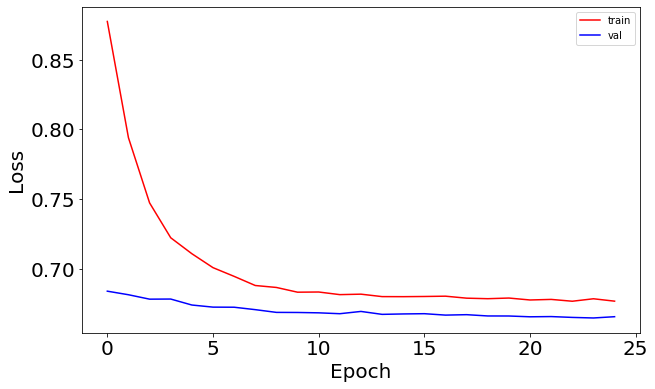

In [41]:
nn_model.plot_loss(history)

In [42]:
nn_preds = model.predict(gr_test)

Graphic written to file ./neural_net/bankroll_images/gauss_rank_FF.png


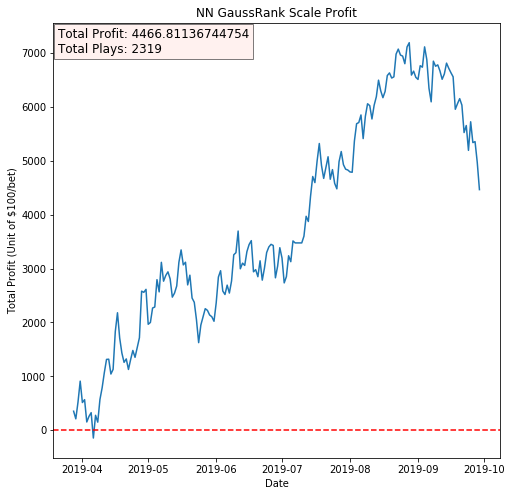

In [49]:
bc = BankrollCalculator(nn_preds, gr_test_target.home_win, gr_test_dates, gr_hc, gr_rc, 
                       fig_title = "NN GaussRank Scale Profit",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/gauss_rank_FF.png")

bc.plot_profit()

In [50]:
nn_model.save_model(model, "./neural_net/gauss_rank.json", "./neural_net/gauss_rank_weights.h5")

Model and weights written to file


In [89]:
vals = []

for i in nn_preds:
    
    vals.append(i[0])
    
model_probs = pd.Series(vals).rename("model_probs")

def model_preds(x):
    
    if x > 0.5:
        
        return(1)
    
    else:
        
        return(0)
    
model_preds = model_probs.apply(lambda x: model_preds(x)).rename("model_preds")

model_payouts = model_probs.apply(lambda x: 1. / x).rename("model_payouts")

model_df = pd.concat([model_probs, model_preds, model_payouts, gr_test_target.home_win,
                     gr_hp, gr_rp, gr_test_dates, gr_hc, gr_rc], axis = 1)

In [90]:
model_df.head()

,model_probs,model_preds,model_payouts,home_win,home_payout,road_payout,date,home_closing,road_closing
0,0.619166,1,1.615076,1,1.980392,1.925926,2019-03-28,-102.0,-108.0
1,0.537335,1,1.861037,0,2.050000,1.869565,2019-03-28,105.0,-115.0
2,0.550092,1,1.817876,1,2.900000,1.476190,2019-03-28,190.0,-210.0
3,0.547986,1,1.824864,1,1.862069,2.060000,2019-03-28,-116.0,106.0
4,0.533789,1,1.873401,1,1.854701,2.070000,2019-03-28,-117.0,107.0


Graphic written to file ./neural_net/bankroll_images/GR_home_dogs.png


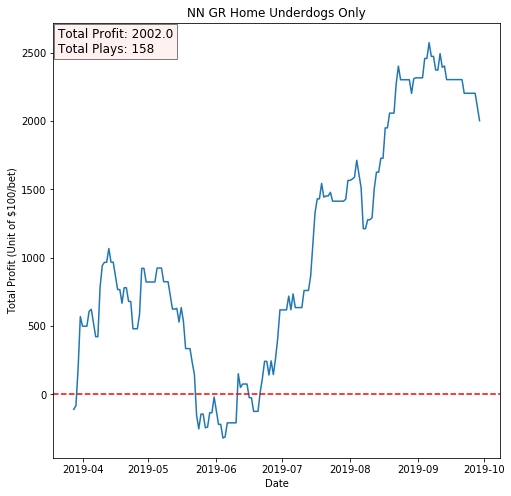

In [92]:
home_dogs = model_df[(model_df.model_payouts < 2) & (model_df.home_payout > 2)].reset_index(drop = True)

bc = BankrollCalculator(home_dogs.model_preds, home_dogs.home_win, home_dogs.date, home_dogs.home_closing,
                        home_dogs.road_closing, fig_title = "NN GR Home Underdogs Only",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/GR_home_dogs.png")

bc.plot_profit()

In [94]:
def create_arbitrage_strategy(df):
    
    indices = []
    
    plays = []
    
    for k in range(len(df)):
        
        if df.iloc[k]["model_payouts"] < 2:
            
            if df.iloc[k]["home_payout"] > 2:
                
                indices.append(k)
                
                plays.append(1)
                
            elif df.iloc[k]["model_payouts"] < df.iloc[k]["home_payout"]:
                
                indices.append(k)
                
                plays.append(1)
                
        else:
            
            if df.iloc[k]["home_payout"] < 2:
                
                indices.append(k)
                
                plays.append(0)
                
            elif df.iloc[k]["home_payout"] < df.iloc[k]["model_payouts"]:
                
                indices.append(k)
                
                plays.append(0)
                
    return(indices, plays)

i, p  = create_arbitrage_strategy(model_df)

In [105]:
arbitrage_df = model_df.iloc[i].reset_index(drop = True)

Graphic written to file ./neural_net/bankroll_images/arbitrage.png


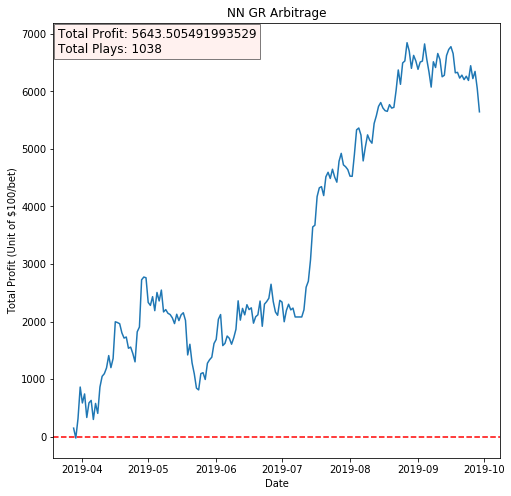

In [108]:
bc = BankrollCalculator(p, arbitrage_df.home_win, arbitrage_df.date, arbitrage_df.home_closing,
                        arbitrage_df.road_closing, fig_title = "NN GR Arbitrage",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/arbitrage.png")

bc.plot_profit()